<a href="https://colab.research.google.com/github/dewizunuvi/Deteksi-Autisme/blob/main/DenseNet121_fix_saved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikasi MRI Autisme ResNet-50**
Gambar Nifti diubah ke 2D, RGB, Dropout

#### Import nibabel package to read NIfTI images

In [16]:
import keras
import numpy as np
import nibabel as nib
import tensorflow as tf
from keras import applications

#### Import all the keras required library

In [17]:
import os
from keras import layers
from google.colab import drive
import matplotlib.pyplot as plt
from keras.models import Sequential, Model 
from keras.losses import categorical_crossentropy
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

#### Fatch all the preprocessed images from the folder, preprocessing is done in SPM (matlab)

In [18]:
# Mount Google Drive
drive.mount('/content/drive')

# Set path to folder containing NIfTI files
folder_path_autism = "/content/drive/MyDrive/Dataset_Autis/Autism"
folder_path_control = "/content/drive/MyDrive/Dataset_Autis/Control"

# daftar file .nii.gz dari folder1
files1 = [os.path.join(folder_path_autism, f) for f in os.listdir(folder_path_autism) if f.endswith('.nii.gz')]

# daftar file .nii.gz dari folder2
files2 = [os.path.join(folder_path_control, f) for f in os.listdir(folder_path_control) if f.endswith('.nii.gz')]

# Load images from the two folders
images1 = [nib.load(f) for f in files1]
images2 = [nib.load(f) for f in files2]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Combine the two sets of images
dataf = images1 + images2

# Generate labels for the images
labels = [1] * len(images1) + [0] * len(images2)

#### Data Conversion from 3D to 2D and introduce 3 channels (RGB) because the predefined model always takes 2D images with 3 channels in Keras.

In [20]:
# create an empty list to store the slice data
slice_list = []

# loop over the images and convert to 2D
for img in images1 + images2:
    # get the image data as a numpy array
    data = img.get_fdata()
    # select a slice to display (e.g. the middle slice along the first axis)
    slice_idx = data.shape[0] // 2
    # extract the 2D slice data
    slice_data = data[slice_idx, :, :]
    # add the slice data to the list
    slice_list.append(slice_data)

In [21]:
len(slice_list)

1102

In [22]:
data_array = np.array(slice_list)

In [23]:
data_array.shape

(1102, 73, 61)

#Turn to RGB

In [24]:
data_image=np.stack([data_array]*3, axis=-1)

In [25]:
data_image.shape

(1102, 73, 61, 3)

#### Split the data into train and test in the 70:30 ratio.

In [26]:
x_train, x_test, y_train, y_test = train_test_split(data_image, labels, test_size=0.4)
y_train=np.array(y_train)


input_shape = (73, 61,3)
x_train = x_train.astype('float32')
y_train = keras.utils.to_categorical(y_train)
y_old_test=y_test
y_test = keras.utils.to_categorical(y_test)


#### Use the ResNet50 model. 

In [27]:
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)  # Add a dropout layer with dropout rate of 0.5
predictions = Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [28]:
model = applications.ResNet50(weights = "imagenet", include_top=False, input_shape =input_shape)


# Freeze the layers which you don't want to train. Here I am not freezing any layer.
for layer in model.layers:
    layer.trainable = True
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)
model= Model(inputs = model.input, outputs = predictions)

In [29]:
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 73, 61, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 79, 67, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 37, 31, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 37, 31, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

#### Compile and train the model with Adam optimizer

In [30]:
model.compile(keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
val=model.fit(x=x_train,y=y_train,batch_size=100, epochs=150,validation_split=0.4)

Epoch 1/150
4/4 [==============================] - 55s 13s/step - loss: 2.1779 - accuracy: 0.4571 - val_loss: 0.6931 - val_accuracy: 0.5245
Epoch 2/150
4/4 [==============================] - 47s 12s/step - loss: 0.6931 - accuracy: 0.5152 - val_loss: 0.6931 - val_accuracy: 0.5245
Epoch 3/150
4/4 [==============================] - 47s 12s/step - loss: 0.6931 - accuracy: 0.5152 - val_loss: 0.6931 - val_accuracy: 0.5245
Epoch 4/150
4/4 [==============================] - 48s 12s/step - loss: 0.6931 - accuracy: 0.5152 - val_loss: 0.6930 - val_accuracy: 0.5245
Epoch 5/150
4/4 [==============================] - 49s 12s/step - loss: 0.6931 - accuracy: 0.5152 - val_loss: 0.6930 - val_accuracy: 0.5245
Epoch 6/150
4/4 [==============================] - 49s 13s/step - loss: 0.6930 - accuracy: 0.5152 - val_loss: 0.6930 - val_accuracy: 0.5245
Epoch 7/150
4/4 [==============================] - 48s 12s/step - loss: 0.6930 - accuracy: 0.5152 - val_loss: 0.6930 - val_accuracy: 0.5245
Epoch 8/150
4/4 [===

#### Save The Model

In [33]:
# Menyimpan model ke dalam file
model.save('modelDenseNetAUTISM.h5')

#### The model loss and accuracy on test data. 

In [31]:
#x_test = X_test.reshape(X_test.shape[0],145,121,3)
x_test = x_test.astype('float32')
    # Normalizing the RGB codes by dividing it to the max RGB value.
print('Number of images in x_test', x_test.shape[0])
model.evaluate(x_test,y_test)


Number of images in x_test 441
14/14 [==============================] - 5s 349ms/step - loss: 0.6926 - accuracy: 0.5170


[0.6925753355026245, 0.5170068144798279]

Text(0, 0.5, 'Accuracy')

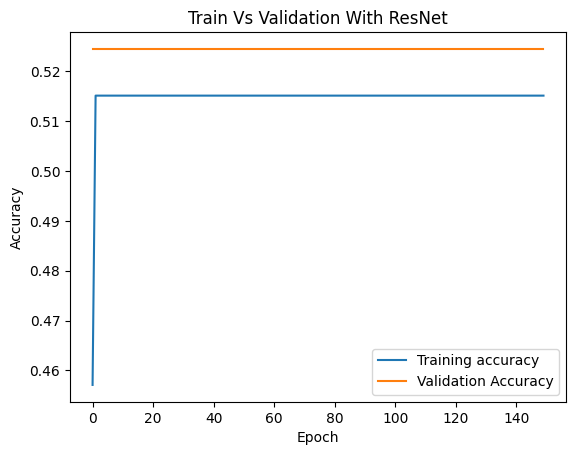

In [32]:
plt.plot(val.history['accuracy'])
plt.plot(val.history['val_accuracy'])
plt.legend(['Training accuracy' ,'Validation Accuracy'])
plt.title("Train Vs Validation With ResNet")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")